In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import IPython
from scipy.optimize import curve_fit
import imageio
import multiprocess as mp

import os,sys,inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir) 

import algorithms as a
import force_functions as f

In [2]:
t_max = 100
dt = .001
lam = 0.1931833275037836
N = 11
L = 11
m = np.ones([N,1])

In [3]:
def init(N, L):
    r0 = np.zeros([N, 3])
    for i in range(1,N+1):
        r0[i-1] = np.array([i-L/2, 0, 0])
    
    p0 = np.zeros([N, 3])
    p0[5] = np.array([-3/7, 6/7, -2/7])
    
    return r0, p0

In [4]:
r0, p0 = init(N=N, L=L)

In [5]:
r, p, t = a.velocity_verlet_Ndim_PBC(r0, p0, t_max, dt, f.chain_force_PBC, L)

100%|██████████| 99999/99999 [00:46<00:00, 2134.80it/s]


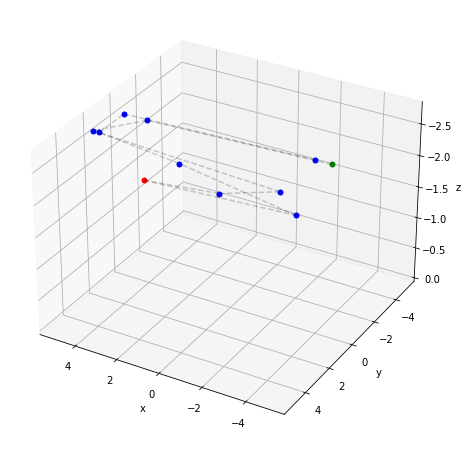

In [6]:
xlim = (r[:,:,0].max(), r[:,:,0].min())
ylim = (r[:,:,1].max(), r[:,:,1].min())
zlim = (r[:,:,2].max(), r[:,:,2].min())
files = []
for i in range(len(t)):
    
    if i%943==1:
        plt.clf()
        fig = plt.figure(figsize=(12,8));
        ax = fig.add_subplot(111, projection='3d')
        for x_i, x in enumerate(r[i]):
            if x_i==5:
                ax.plot(x[0], x[1], x[2], color='red', linestyle='', marker='o', markersize=5)
            elif x_i == N-1:
                ax.plot(x[0], x[1], x[2], color='blue', linestyle='', marker='o', markersize=5)
            elif x_i == 0:
                ax.plot(x[0], x[1], x[2], color='green', linestyle='', marker='o', markersize=5)
            else:
                ax.plot(x[0], x[1], x[2], color='blue', linestyle='', marker='o', markersize=5)
        
        bonds = np.stack((r[i][:-1], r[i][1:]), axis=1)
        end2end = np.vstack((r[i][-1], r[i][0]))
        
        for b in bonds:
            ax.plot(b[:,0], b[:,1], b[:,2], linestyle='--', color='black', alpha=0.2)
        #ax.plot(end2end[:,0], end2end[:,1], end2end[:,2], linestyle='-', color='black')
        
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.set_zlim(zlim)
        
        filename = f'./figures/frame_{int(i/943)}.png'
        plt.savefig(filename)
        files.append(filename)
        
        plt.draw()
        IPython.display.clear_output(wait=True)
        IPython.display.display(fig)
    plt.close()
IPython.display.clear_output(wait=True)

In [7]:
with imageio.get_writer('./figures/3d_trajectory.gif', mode='I', fps=5) as writer:
    for file in files:
        image = imageio.imread(file)
        os.remove(file)
        writer.append_data(image)

In [9]:
def center_of_mass(r, m):
    M = m.sum()
    r_cm = (m*r).sum(axis=0) / M
    return r_cm

In [10]:
r_cm = np.zeros([len(t), 3])
for i in tqdm(range(len(t))):
    r_cm[i] = center_of_mass(r[i],m)

100%|██████████| 100000/100000 [00:01<00:00, 67693.07it/s]


In [11]:
def harmonic_chain_potential(r, k=1):
    return .5 * k * np.linalg.norm(r[1:] - r[:-1])**2

In [12]:
def kinetic_energy(p,m):
    T = 0
    for i in range(len(m)):
        T += 0.5 * np.linalg.norm(p[i])**2 / m[i]
    return float(T)

In [13]:
def total_energy(r,p,m):
    E = np.zeros(r.shape[0])
    for i in tqdm(range(r.shape[0])):
        E[i] += harmonic_chain_potential(r[i],k=1)
        E[i] += kinetic_energy(p[i],m)
    return E  


In [14]:
V = np.zeros(r.shape[0])
T = np.zeros(r.shape[0])
for i in tqdm(range(r.shape[0])):
        V[i] = harmonic_chain_potential(r[i],k=1)
        T[i] = kinetic_energy(p[i],m)

100%|██████████| 100000/100000 [00:16<00:00, 5969.06it/s]


-0.9234605291363168

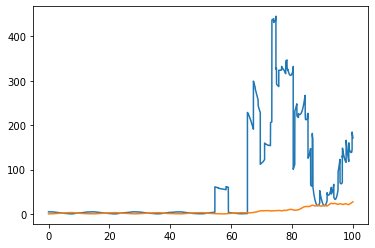

In [15]:
plt.plot(t,V)
plt.plot(t,T)
E = T + V
np.max(x)

No handles with labels found to put in legend.


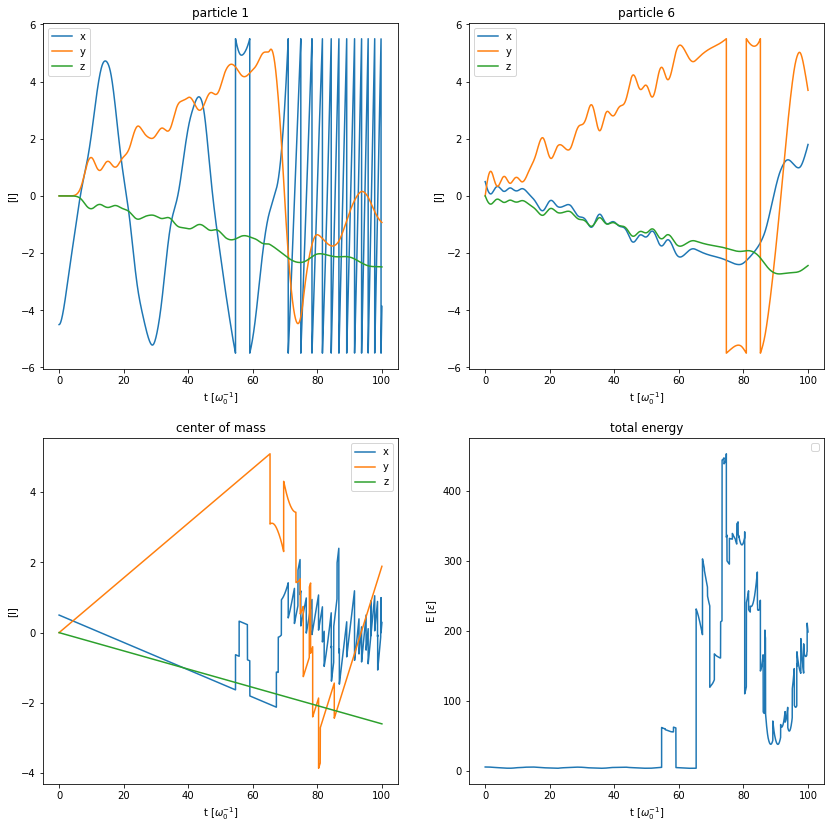

In [16]:
cols = 2
rows = 2

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(cols*7, rows*7))
axes[0,0].plot(t,r[:,0,0],  label='x')
axes[0,0].plot(t,r[:,0,1],  label='y')
axes[0,0].plot(t,r[:,0,2],  label='z')
axes[0,0].set_title('particle 1')
axes[0,0].set_ylabel('l')
axes[0,1].plot(t,r[:,5,0], label='x')
axes[0,1].plot(t,r[:,5,1],  label='y')
axes[0,1].plot(t,r[:,5,2],  label='z')
axes[0,1].set_title('particle 6')
axes[0,0].set_ylabel('l')
axes[1,0].plot(t,r_cm[:,0], label='x')
axes[1,0].plot(t,r_cm[:,1], label='y')
axes[1,0].plot(t,r_cm[:,2], label='z')
axes[1,0].set_title('center of mass')
axes[1,1].plot(t, E)
axes[1,1].set_title('total energy')
for i in range(rows):
    for j in range(cols):
        axes[i,j].legend()
        axes[i,j].set_xlabel(r't $[\omega_0^{-1}]$')
        axes[i,j].set_ylabel(r'[l]')
axes[1,1].set_ylabel(r'E $[\epsilon]$')
plt.savefig('assignment51a', dpi=600, bbox_inches='tight')
plt.show()

In [17]:
r02, p02 = init(N=N, L=L)

In [18]:
r2, p2, t2 = a.velocity_verlet_Ndim_PBC(r02, p02, t_max, dt, f.chain_force_closed, L)

100%|██████████| 99999/99999 [00:23<00:00, 4309.88it/s]


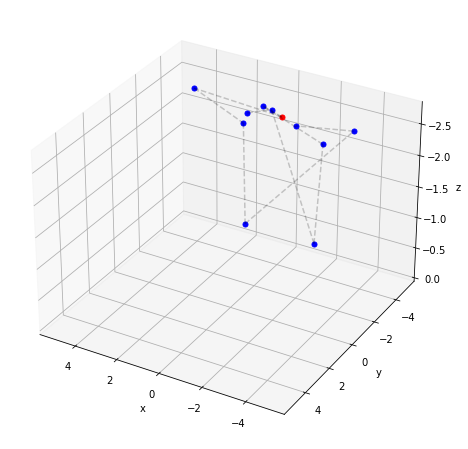

In [19]:
xlim = (r[:,:,0].max(), r[:,:,0].min())
ylim = (r[:,:,1].max(), r[:,:,1].min())
zlim = (r[:,:,2].max(), r[:,:,2].min())
files = []
for i in range(len(t)):
    
    if i%943==0:
        plt.clf()
        fig = plt.figure(figsize=(12,8));
        ax = fig.add_subplot(111, projection='3d')
        for x_i, x in enumerate(r2[i]):
            if x_i==5:
                ax.plot(x[0], x[1], x[2], color='red', linestyle='', marker='o', markersize=5)
            elif x_i == N-1:
                ax.plot(x[0], x[1], x[2], color='blue', linestyle='', marker='o', markersize=5)
            else:
                ax.plot(x[0], x[1], x[2], color='blue', linestyle='', marker='o', markersize=5)
        
        bonds = np.stack((r2[i][:-1], r2[i][1:]), axis=1)
        end2end = np.vstack((r2[i][-1], r2[i][0]))
        
        for b in bonds:
            ax.plot(b[:,0], b[:,1], b[:,2], linestyle='--', color='black', alpha=0.2)
        #ax.plot(end2end[:,0], end2end[:,1], end2end[:,2], linestyle='-', color='black')
        
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.set_zlim(zlim)
        
        filename = f'./figures/frame_{int(i/943)}_closed.png'
        plt.savefig(filename)
        files.append(filename)
        
        plt.draw()
        IPython.display.clear_output(wait=True)
        IPython.display.display(fig)
    plt.close()
IPython.display.clear_output(wait=True)

In [38]:
with imageio.get_writer('./figures/3d_trajectory2.gif', mode='I', fps=5) as writer:
    for file in files:
        image = imageio.imread(file)
        os.remove(file)
        writer.append_data(image)

In [39]:
r2_cm = np.zeros([len(t), 3])
for i in tqdm(range(len(t))):
    r2_cm[i] = center_of_mass(r2[i],m)

100%|██████████| 100000/100000 [00:01<00:00, 75925.16it/s]


In [40]:
E2 = total_energy(r2,p2,m)

100%|██████████| 100000/100000 [00:14<00:00, 6949.80it/s]


No handles with labels found to put in legend.


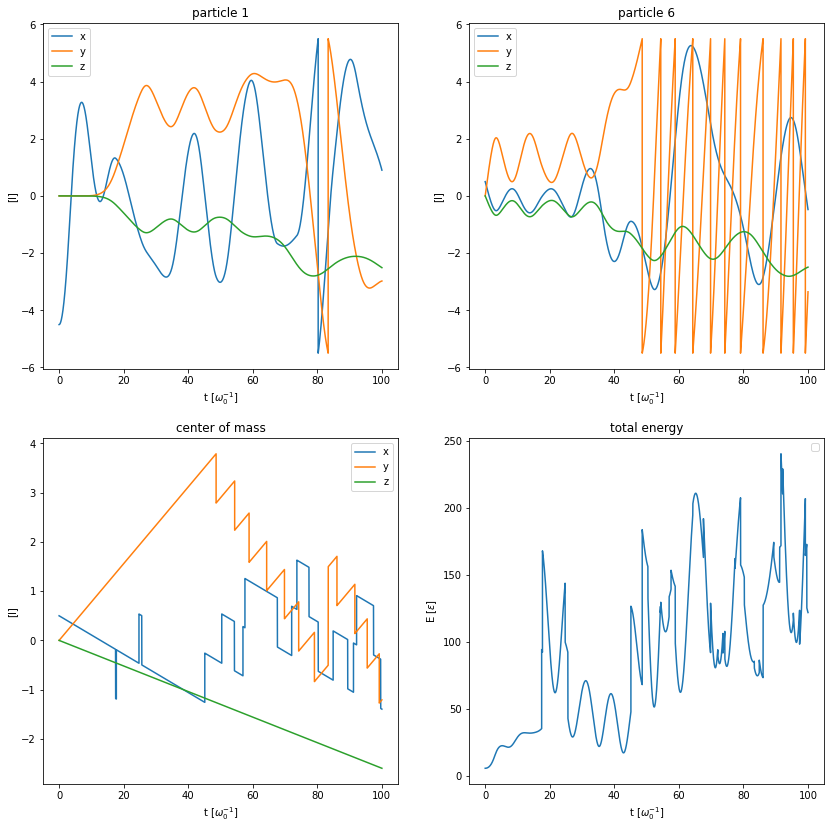

In [41]:
cols = 2
rows = 2

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(cols*7, rows*7))
axes[0,0].plot(t,r2[:,0,0],  label='x')
axes[0,0].plot(t,r2[:,0,1],  label='y')
axes[0,0].plot(t,r2[:,0,2],  label='z')
axes[0,0].set_title('particle 1')
axes[0,0].set_ylabel('l')
axes[0,1].plot(t,r2[:,5,0], label='x')
axes[0,1].plot(t,r2[:,5,1],  label='y')
axes[0,1].plot(t,r2[:,5,2],  label='z')
axes[0,1].set_title('particle 6')
axes[0,0].set_ylabel('l')
axes[1,0].plot(t,r2_cm[:,0], label='x')
axes[1,0].plot(t,r2_cm[:,1], label='y')
axes[1,0].plot(t,r2_cm[:,2], label='z')
axes[1,0].set_title('center of mass')
axes[1,1].plot(t, E2)
axes[1,1].set_title('total energy')
for i in range(rows):
    for j in range(cols):
        axes[i,j].legend()
        axes[i,j].set_xlabel(r't $[\omega_0^{-1}]$')
        axes[i,j].set_ylabel(r'[l]')
axes[1,1].set_ylabel(r'E $[\epsilon]$')
plt.savefig('assignment51b', dpi=600, bbox_inches='tight')
plt.show()